In [2]:
# 다운로드가 필요한 모듈, 라이브러리
# pip install lightgbm
# pip install catboost
# pip install soccerdata
# pip install xgboost
# pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score, accuracy_score

from soccerdata.fbref import FBref 
from pathlib import Path

# 학습 모델들
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

[07/03/25 15:25:36] INFO     No custom team name replacements found. You can configure these in       ]8;id=981740;file://c:\project\module_project\.venv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=215400;file://c:\project\module_project\.venv\lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\User\soccerdata\config\teamname_replacements.json.                           

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=697817;file://c:\project\module_project\.venv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=851477;file://c:\project\module_project\.venv\lib\site-packages\soccerdata\_config.py#197\197]8;;\
                             C:\Users\User\soccerdata\config\league_dict.json.                                     

In [4]:
# 1) CSV 불러오기 & match_id 생성
data = pd.read_csv('Matches.csv', parse_dates=['MatchDate'])
data = data.reset_index().rename(columns={'index':'match_id'})

# 2) 홈/원정 각각 long 포맷으로 전환
home = data[['match_id','MatchDate','HomeTeam','FTHome','FTAway']].copy()
home = home.assign(
    team           = home['HomeTeam'],
    goals_for      = home['FTHome'],
    goals_against  = home['FTAway'],
    venue          = 'Home'
)[['match_id','MatchDate','team','goals_for','goals_against','venue']]

away = data[['match_id','MatchDate','AwayTeam','FTAway','FTHome']].copy()
away = away.assign(
    team           = away['AwayTeam'],
    goals_for      = away['FTAway'],
    goals_against  = away['FTHome'],
    venue          = 'Away'
)[['match_id','MatchDate','team','goals_for','goals_against','venue']]

matches_long = pd.concat([home, away], ignore_index=True)

# 3) 정렬하고 인덱스 재설정 (꼭 필요)
matches_long = matches_long.sort_values(['team','MatchDate']).reset_index(drop=True)

# 4) 과거 3·5경기 득실 합계 계산 (transform 이용)
for N in (3, 5):
    # 먼저 “현재 경기” 제외를 위해 shift()
    shifted_gf = matches_long.groupby('team')['goals_for']     .shift()
    shifted_ga = matches_long.groupby('team')['goals_against'] .shift()

    # rolling 합계 계산
    matches_long[f'GF{N}'] = (shifted_gf
                              .groupby(matches_long['team'])
                              .transform(lambda x: x.rolling(N).sum()))
    matches_long[f'GA{N}'] = (shifted_ga
                              .groupby(matches_long['team'])
                              .transform(lambda x: x.rolling(N).sum()))

# 5) 홈/Away별로 다시 뽑아서 이름 바꾸기
home_stats = (
    matches_long[matches_long['venue']=='Home']
    .set_index('match_id')[['GF3','GA3','GF5','GA5']]
    .rename(columns={
        'GF3':'GF3Home','GA3':'GA3Home',
        'GF5':'GF5Home','GA5':'GA5Home'
    })
)
away_stats = (
    matches_long[matches_long['venue']=='Away']
    .set_index('match_id')[['GF3','GA3','GF5','GA5']]
    .rename(columns={
        'GF3':'GF3Away','GA3':'GA3Away',
        'GF5':'GF5Away','GA5':'GA5Away'
    })
)

# 6) map으로 원본 data에 컬럼 추가
for col in home_stats.columns:
    data[col] = data['match_id'].map(home_stats[col])
for col in away_stats.columns:
    data[col] = data['match_id'].map(away_stats[col])

# 7) 불필요해진 match_id 제거 (선택)
data = data.drop(columns=['match_id'])

# 8) 결과 확인
# data.info()

In [5]:
data = data[data['Division'] == 'E0']   # 프리미어 리그(epl) 데이터 추출

# 1-1 xg 데이터 불러오기
xg_data = pd.read_csv('xg_data.csv')

# 1-2 xg 데이터와 Matches 데이터 합치기

# 날짜 칼럼을 datetime.date 로 맞추기
xg_data['MatchDate'] = pd.to_datetime(xg_data['MatchDate']).dt.date
data['MatchDate'] = pd.to_datetime(data['MatchDate']).dt.date 

# Mathces와 다른 팀명들을 모두 동일하도록 mapping
team_name_map = {
    'Manchester City'   : 'Man City',
    'Manchester United' : 'Man United',
    'Newcastle United' : 'Newcastle',
    'Nottingham Forest' : 'Nottm Forest',
    'Wolverhampton Wanderers' : 'Wolves',
    'West Bromwich Albion' : 'West Brom',
}   

# xg_data 에 적용 (Home / Away 양쪽)
xg_data['HomeTeam'] = xg_data['HomeTeam'].replace(team_name_map)
xg_data['AwayTeam'] = xg_data['AwayTeam'].replace(team_name_map)



# MatchDate를 시계열 데이터로 전환
xg_data['MatchDate'] = pd.to_datetime(xg_data['MatchDate'])  # MatchDate를 datetime 형식으로 변환
data['MatchDate'] = pd.to_datetime(data['MatchDate'])  # MatchDate를 datetime 형식으로 변환
data = data[(data['MatchDate'] > '2016-08-13')]


# xg_data와 Matches 데이터 합치기
data_final = data.merge(
    xg_data,
    on=['MatchDate', 'HomeTeam', 'AwayTeam'],
    how='inner',          # 이전에 left
    validate='1:1'        # 같은 키가 중복되면 오류로 알려줌
)

In [6]:
# 2. 데이터 전처리
# 2-1 데이터 전처리 :데이터 연도 기준 필터링
# 프리미어 리그(epl)의 2022~2023연도 데이터를 사용


# 2-2 데이터 전처리 : 학습에 사용할 column만 추출
# 'MatchTime' 제거
columns = ['MatchDate', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'OddHome', 'OddDraw', 'OddAway', 'FTResult', 'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away', 'GF5Away', 'GA5Away', 'home_goals_l3', 'home_goals_l5', 'away_goals_l3', 'away_goals_l5', 'home_xg_l3', 'home_xg_l5', 'away_xg_l3', 'away_xg_l5'
]
data_final = data_final[columns]

In [7]:
# 2-3 데이터 전처리 : 결측치 확인
data_final.isnull().sum()

# 결측치는 학습에 영향을 주지 않도록 모두 0으로 처리 
columns_NaN = ['home_goals_l3', 'home_goals_l5', 'away_goals_l3', 'away_goals_l5', 'home_xg_l3', 'home_xg_l5', 'away_xg_l3', 'away_xg_l5']

# 결측치 있는 행 제거
data_final[columns_NaN] = data_final[columns_NaN].fillna(0)

# data_final = data_final.dropna(subset=columns).copy()

In [8]:
# 2-4 데이터 전처리 : Standardize(표준화), OneHotEncoding(원-핫 인코딩)
log_columns = ['HomeElo', 'AwayElo', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiHome', 'HandiAway'] # 로그 변환할 columns
standarize_columns = ['HomeElo', 'AwayElo', 'OddHome', 'OddDraw', 'OddAway', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'HandiSize', 'HandiHome', 'HandiAway', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away', 'GF5Away', 'GA5Away']  # 표준화할 columns
encoding_columns = ['HomeTeam', 'AwayTeam']  # 원-핫 인코딩할 columns

# 분산이 큰 배당률 관련 columns와 Elo columns는 표준화 전에 log scale을 먼저 적용
data_final[log_columns] = np.log1p(data_final[log_columns])

# Pipeline에서 전처리 해줄 ColumnsTransformer 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), standarize_columns),  # 표준화
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True), encoding_columns)  # 원-핫 인코딩
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)


In [ ]:
# 팀의 전력 차이를 예측하기 위한 파생 column 생성

# home과 away의 xG차이
data_final['xg_l3_diff'] = data_final['home_xg_l3'] - data_final['away_xg_l3']  
data_final['xg_l5_diff'] = data_final['home_xg_l5'] - data_final['away_xg_l5']

# home과 away의 Elo 차이
data_final['elo_diff'] = data_final['HomeElo'] - data_final['AwayElo']  



In [32]:
pd.DataFrame.to_csv(data_final, 'data_final.csv', index=False)

In [ ]:
# 1) 학습·테스트 시즌 분리
train_mask = (data_final['MatchDate'] > '2016-08-13') & (data_final['MatchDate'] < '2025-01-01')
test_mask  =  data_final['MatchDate'] >= '2025-01-01'

data_train = data_final.loc[train_mask].copy()
data_test  = data_final.loc[test_mask].copy()

# 2) 무승부(Draw) 제거 → Home=0, Away=1
data_train = data_train[data_train['FTResult'] != 'D']
data_test  = data_test[data_test['FTResult']  != 'D']

target_map = {'H': 0, 'A': 1}

# 3) MatchDate 컬럼 삭제
data_train.drop(columns='MatchDate', inplace=True)
data_test.drop(columns='MatchDate', inplace=True)

# 4) feature 컬럼 자동 도출 & 분리
features = [c for c in data_train.columns if c != 'FTResult']

X_train = data_train[features]
X_test  = data_test[features]

y_train = data_train['FTResult'].map(target_map)
y_test  = data_test['FTResult'].map(target_map)


# 학습용/검증용 데이터 분리
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,                       # ← 앞서 만든 0/1 데이터
    test_size=0.20,
    stratify=y_train,
    random_state=42
)






In [24]:
rf = ExtraTreesClassifier(
        n_estimators   = 1900,        #
        max_depth      = 10,          # 이전에 10
        max_features   = 0.25,         # 이전에 0.3
        min_samples_leaf = 15,         # 이전에 10
        n_jobs         = -1,
        class_weight   = 'balanced_subsample',
        random_state   = 42
)



In [25]:
pipe_extra = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', rf)                
])


In [26]:
from sklearn.calibration import CalibratedClassifierCV

cal_et = CalibratedClassifierCV(
    pipe_extra, 
    cv=5,
    method='isotonic'
)

cal_et.fit(X_train, y_train)

# 홀드-아웃 검증
proba_val = cal_et.predict_proba(X_val)[:, 1]
print("AUC  (cal):", round(roc_auc_score(y_val, proba_val), 3))
print("LogLoss(cal):", round(log_loss(y_val, proba_val), 3), '\n')

# 5-fold CV 성능 (원본 파이프라인)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe_extra, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"AUC (5-fold) : {auc.mean():.3f} ± {auc.std():.3f}")

AUC  (cal): 0.816
LogLoss(cal): 0.513 

AUC (5-fold) : 0.786 ± 0.017


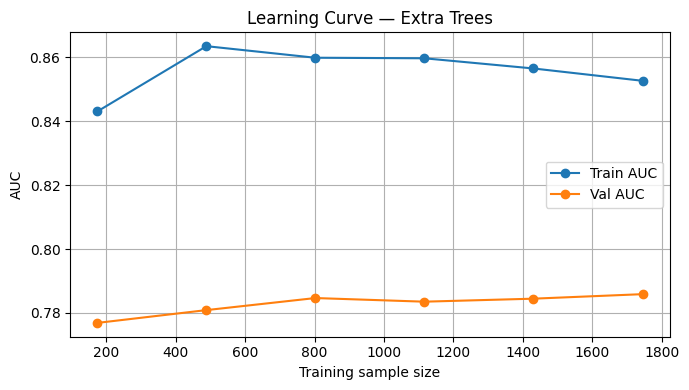

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
import pandas as pd

# NOTE: The variables `pipe` (your ExtraTrees pipeline),
#        `X_train`, `y_train` should already be defined in your notebook.
# If the code below raises NameError, run the cell where `pipe`, `X_train`, `y_train` are created.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1) Learning curve for AUC
train_sizes, train_scores, val_scores = learning_curve(
    pipe_extra, X_train, y_train,
    cv=cv, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 6),   # 10%, …, 100%
    n_jobs=-1, shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_mean, marker='o', label='Train AUC')
plt.plot(train_sizes, val_mean,   marker='o', label='Val AUC')
plt.xlabel("Training sample size")
plt.ylabel("AUC")
plt.title("Learning Curve — Extra Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Train vs Val metrics on full data (5-fold CV) — table
from sklearn.model_selection import cross_validate

scoring = {"auc":"roc_auc", "logloss":"neg_log_loss", "acc":"accuracy"}
cv_res = cross_validate(pipe_extra, X_train, y_train,
                        cv=cv, scoring=scoring, return_train_score=True)

metrics_df = pd.DataFrame({
    "Metric": ["AUC", "LogLoss", "Accuracy"],
    "Train mean": [cv_res["train_auc"].mean(),
                   -cv_res["train_logloss"].mean(),
                   cv_res["train_acc"].mean()],
    "Val mean":   [cv_res["test_auc"].mean(),
                   -cv_res["test_logloss"].mean(),
                   cv_res["test_acc"].mean()],
    "Gap":        [cv_res["train_auc"].mean() - cv_res["test_auc"].mean(),
                   (-cv_res["train_logloss"].mean()) - (-cv_res["test_logloss"].mean()),
                   cv_res["train_acc"].mean() - cv_res["test_acc"].mean()]
})


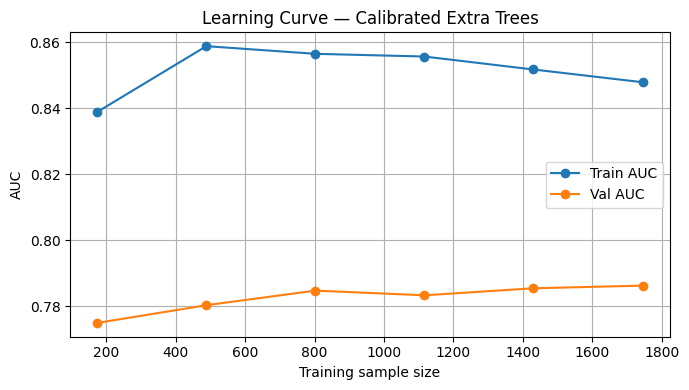

     Metric  Train mean  Val mean       Gap
0       AUC    0.847181  0.785040  0.062140
1   LogLoss    0.479661  0.599479 -0.119817
2  Accuracy    0.770737  0.716313  0.054424


In [28]:
# 1) Learning curve – 사용 모델을 cal_et 로!
train_sizes, train_scores, val_scores = learning_curve(
    cal_et,           # ← 여기를 cal_et로 교체
    X_train, y_train,
    cv=cv, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1, shuffle=True, random_state=42
)

# 곡선 그리기
plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1),   marker='o', label='Val AUC')
plt.xlabel("Training sample size"); plt.ylabel("AUC")
plt.title("Learning Curve — Calibrated Extra Trees")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 2) 5-fold Train vs Val 지표
scoring = {"auc":"roc_auc", "logloss":"neg_log_loss", "acc":"accuracy"}
cv_res = cross_validate(cal_et, X_train, y_train,
                        cv=cv, scoring=scoring,
                        return_train_score=True, n_jobs=-1)

metrics_df = pd.DataFrame({
    "Metric": ["AUC", "LogLoss", "Accuracy"],
    "Train mean": [cv_res["train_auc"].mean(),
                   -cv_res["train_logloss"].mean(),
                   cv_res["train_acc"].mean()],
    "Val mean":   [cv_res["test_auc"].mean(),
                   -cv_res["test_logloss"].mean(),
                   cv_res["test_acc"].mean()],
    "Gap":        [cv_res["train_auc"].mean() - cv_res["test_auc"].mean(),
                   (-cv_res["train_logloss"].mean()) - (-cv_res["test_logloss"].mean()),
                   cv_res["train_acc"].mean() - cv_res["test_acc"].mean()]
})
print(metrics_df)

In [31]:
cal_et_final = CalibratedClassifierCV(
    estimator=pipe_extra,
    method='isotonic',
    cv=cv
).fit(X_train, y_train)

# 2) 테스트셋 예측
proba_test = cal_et_final.predict_proba(X_test)[:, 1]
pred_test  = (proba_test > 0.50).astype(int)   # 임계값 0.5

# 3) 지표 출력
print("=== Final Test Metrics (2025 시즌) ===")
print(f"AUC       : {roc_auc_score(y_test, proba_test):.3f}")
print(f"Log-loss  : {log_loss(y_test, proba_test):.3f}")
print(f"Accuracy  : {accuracy_score(y_test, pred_test):.3f}\n")

print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test), "\n")
print("Classification Report:\n",
      classification_report(y_test, pred_test, digits=3))

=== Final Test Metrics (2025 시즌) ===
AUC       : 0.813
Log-loss  : 0.544
Accuracy  : 0.720

Confusion Matrix:
 [[67  8]
 [32 36]] 

Classification Report:
               precision    recall  f1-score   support

           0      0.677     0.893     0.770        75
           1      0.818     0.529     0.643        68

    accuracy                          0.720       143
   macro avg      0.747     0.711     0.706       143
weighted avg      0.744     0.720     0.710       143

